- 16 aziende (sorgenti), 19 files totali (4 relativi alla stessa azienda ariregister)
- 21 MB di spazio, ~1MB a sorgente


In [1]:
import pandas as pd
import os 
import json
import seaborn as sns
import matplotlib.pyplot as plt

SRC = 'sources/'

In [2]:
schemas = []
for filename in os.listdir(SRC):
    file_path = os.path.join(SRC, filename)
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    elif file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.json_normalize(data)
        else:
            df = pd.json_normalize([data])
    elif file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.jsonl'):
        df = pd.read_json(file_path, lines=True)
    else: 
        print(f"Unsupported file type: {file_path}")
        continue    

    schema = {col: str(dtype) for col, dtype in zip(df.columns, df.dtypes)}
    schemas.append({"file": filename, "schema": schema})

In [3]:
all_columns = set()
for schema in schemas:
    all_columns.update(schema["schema"].keys())

comparison = []
for col in all_columns:
    col_info = {"Column": col}
    for schema in schemas:
        col_info[schema["file"]] = schema["schema"].get(col, pd.NA)
    comparison.append(col_info)

schema_comparison = pd.DataFrame(comparison)
display(schema_comparison)

,Column,AmbitionBox.csv,campaignindia.csv,companiesMarketCap_dataset.jsonl,company_social_urls.csv,DDD-cbinsight.com.csv,DDD-teamblind.com.csv,disfold.com.json,ft.com.json,hitHorizons_dataset.jsonl,MalPatSaj-forbes.com.xls,MalPatSaj-wikipedia.org.xls,output_globaldata.json,output_govuk_bigsize.json,valueToday_dataset.jsonl,wissel-activity-ariregister.rik.ee.csv,wissel-aziende-ariregister.rik.ee.csv,wissel-aziende-info-clipper.com.csv,wissel-partners-ariregister.rik.ee.csv,wissel-rappresentanti-ariregister.rik.ee.csv
0,Legal form,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>
1,Capital,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>
2,world_rank,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>
3,name,<NA>,<NA>,object,<NA>,object,object,object,object,object,<NA>,<NA>,object,object,object,<NA>,<NA>,<NA>,<NA>,<NA>
4,Name,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,object,<NA>,<NA>,<NA>,<NA>,object,object,object,object
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,company_status,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
99,employees,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
100,company_creation_date,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
101,est_of_ownership,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,int64,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [8]:
# Save the comparison to a CSV file
output = "schema_comparison.csv"
schema_comparison['Column'] = schema_comparison['Column'].str.lower()  
schema_comparison = schema_comparison.sort_values(by="Column", ascending=True)
schema_comparison.columns = schema_comparison.columns.str.strip()
schema_comparison['Column'] = schema_comparison['Column'].str.strip()
schema_comparison.to_csv(output, index=False)

### Some stats

In [4]:
# Extract some stats

# Sort and display the most common attributes
attribute_coverage = schema_comparison.set_index('Column').notna().sum(axis=1)
attribute_coverage = attribute_coverage.sort_values(ascending=False)
print(attribute_coverage)


Column
name                              9
Name                              7
industry                          5
Unnamed: 0                        5
market_cap                        3
                                 ..
type                              1
Address Name                      1
Registration Date                 1
Postalcode                        1
annual_results_for_year_ending    1
Length: 103, dtype: int64


In [5]:
# Count available attributes per data source
source_completeness = schema_comparison.set_index('Column').notna().sum(axis=0)
print("Attributes per source:\n", source_completeness.sort_values(ascending=False))

Attributes per source:
 valueToday_dataset.jsonl                        18
DDD-cbinsight.com.csv                           11
wissel-aziende-info-clipper.com.csv             11
wissel-aziende-ariregister.rik.ee.csv           10
companiesMarketCap_dataset.jsonl                 9
hitHorizons_dataset.jsonl                        9
output_globaldata.json                           9
MalPatSaj-forbes.com.xls                         7
DDD-teamblind.com.csv                            7
ft.com.json                                      7
MalPatSaj-wikipedia.org.xls                      7
output_govuk_bigsize.json                        7
disfold.com.json                                 6
wissel-partners-ariregister.rik.ee.csv           5
AmbitionBox.csv                                  5
wissel-activity-ariregister.rik.ee.csv           5
campaignindia.csv                                5
company_social_urls.csv                          5
wissel-rappresentanti-ariregister.rik.ee.csv     5
dtype: 

In [11]:
# Check attributes present in all sources
common_attributes = schema_comparison.set_index('Column').notna().all(axis=1)

# Properly filter rows using the correct index
common_attributes_list = schema_comparison.loc[common_attributes[common_attributes].index, 'Column'].tolist()
print("Attributes in all sources:\n", common_attributes_list)

Attributes in all sources:
 []


In [12]:
# Count occurrences of each type
type_counts = schema_comparison.set_index('Column').apply(pd.Series.value_counts).fillna(0)
print("Data type counts across sources:\n", type_counts)

Data type counts across sources:
          wissel-activity-ariregister.rik.ee.csv  DDD-teamblind.com.csv  \
float64                                       1                      1   
int64                                         1                      1   
object                                        3                      5   

         wissel-aziende-info-clipper.com.csv  output_govuk_bigsize.json  \
float64                                  0.0                        0.0   
int64                                    2.0                        0.0   
object                                   9.0                        7.0   

         MalPatSaj-wikipedia.org.xls  wissel-aziende-ariregister.rik.ee.csv  \
float64                          0.0                                      1   
int64                            1.0                                      1   
object                           6.0                                      8   

         ft.com.json  disfold.com.json  campaignind

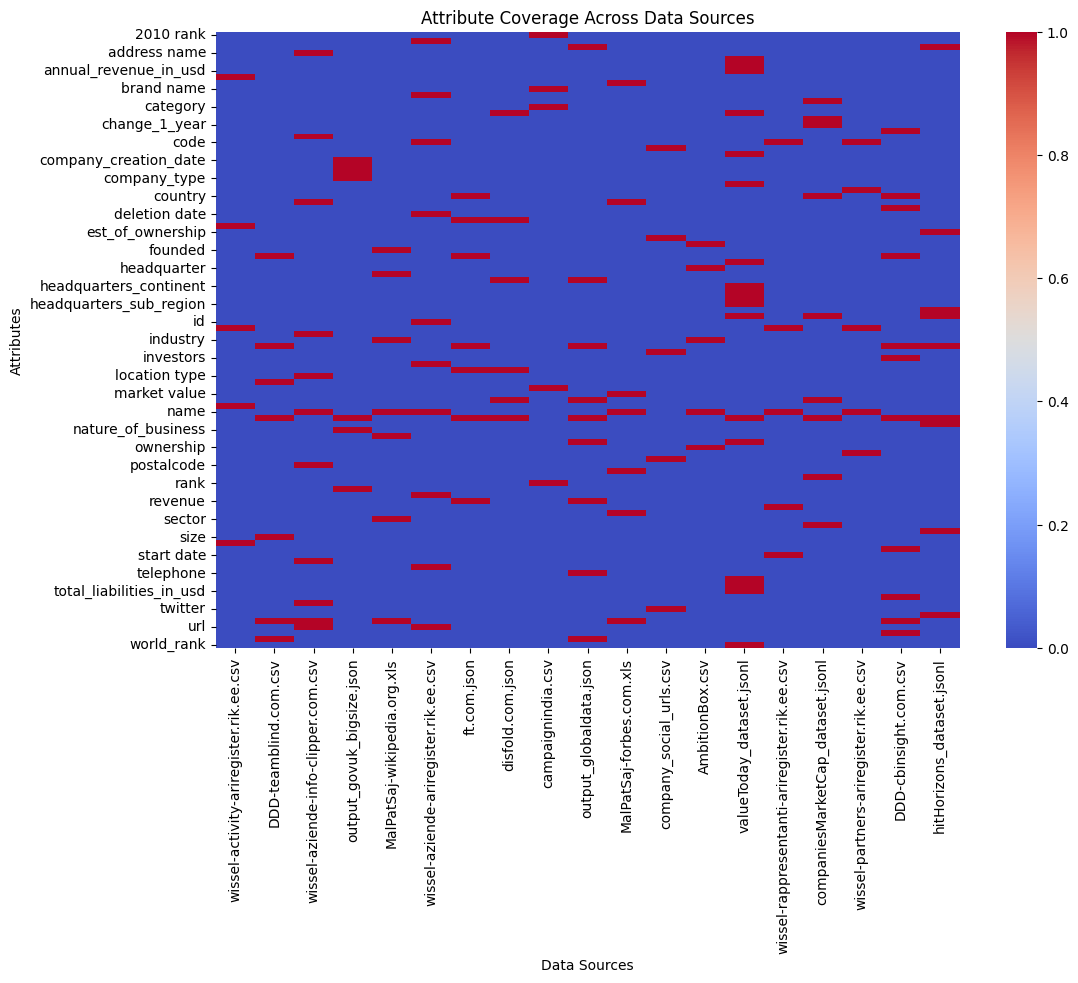

In [13]:
# Convert to binary presence/absence for heatmap visualization
binary_df = schema_comparison.set_index('Column').notna().astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(binary_df, cmap='coolwarm', cbar=True)
plt.title('Attribute Coverage Across Data Sources')
plt.xlabel('Data Sources')
plt.ylabel('Attributes')
plt.show()

In [7]:
row_counts = []
for schema in schemas:
    filename = schema['file']
    file_path = os.path.join(SRC, filename)
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    elif file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.json_normalize(data)
        else:
            df = pd.json_normalize([data])
    elif file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.jsonl'):
        df = pd.read_json(file_path, lines=True)
    else:
        print(f"Unsupported file type: {file_path}")
        continue
    
    row_counts.append({"file": filename, "row_count": len(df)})

row_counts_df = pd.DataFrame(row_counts)
display(row_counts_df)
print(row_counts_df['row_count'].sum())	

,file,row_count
0,AmbitionBox.csv,9899
1,campaignindia.csv,1000
2,companiesMarketCap_dataset.jsonl,5897
3,company_social_urls.csv,848
4,DDD-cbinsight.com.csv,1185
5,DDD-teamblind.com.csv,946
6,disfold.com.json,16097
7,ft.com.json,5000
8,hitHorizons_dataset.jsonl,667
9,MalPatSaj-forbes.com.xls,2000


79004


### Analisi schema mediato popolato

In [2]:
import pandas as pd

df = pd.read_csv('output_other_sorted.csv')

display(df.head())

,name,category,address,city,country,yearFoundation,founders,link,rank,market_cap,employees,ceo,assets,profit,sales,revenue,telephone,iban,sic_code,facebook
0,"""ALL ABOUT ME"" FULL STOP LIMITED",82990 - Other business support service activit...,NaN,NaN,NaN,13 August 2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"""Q"" (CHESTER GREEN) MANAGEMENT COMPANY LIMITED",98000 - Residents property management,NaN,NaN,NaN,27 September 2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#sinob,Retail,NaN,NaN,Germany,2015,NaN,https://www.sinob.de/,NaN,NaN,14,NaN,NaN,NaN,NaN,4.95,NaN,NaN,NaN,NaN
3,'ALL ABOARD' SHOPS LIMITED,88990 - Other social work activities without a...,NaN,NaN,NaN,4 January 1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,'Q' ACCOUNTANCY SERVICES LIMITED,69201 - Accounting and auditing activities,NaN,NaN,NaN,21 April 1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
